# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig1030s0"     # Used for tflite Filename
Training_Percentage = 0.2              # 0.0 = Use all Images for Training
Epoch_Anz = 500

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '/*.jpg')
    if aktsubdir == "NaN":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        x_data.append(test_image)
        y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1310, 32, 20, 3)
(1310, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 64)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/500
328/328 [==============================] - 13s 28ms/step - loss: 2.1565 - accuracy: 0.3496 - val_loss: 1.2569 - val_accuracy: 0.5840
Epoch 2/500
328/328 [==============================] - 5s 14ms/step - loss: 1.2115 - accuracy: 0.6126 - val_loss: 0.7122 - val_accuracy: 0.7786
Epoch 3/500
328/328 [==============================] - 5s 14ms/step - loss: 0.8325 - accuracy: 0.7386 - val_loss: 0.5895 - val_accuracy: 0.8244
Epoch 4/500
328/328 [==============================] - 5s 14ms/step - loss: 0.7058 - accuracy: 0.8041 - val_loss: 0.4263 - val_accuracy: 0.8702
Epoch 5/500
328/328 [==============================] - 5s 14ms/step - loss: 0.5781 - accuracy: 0.8256 - val_loss: 0.4574 - val_accuracy: 0.8702
Epoch 6/500
328/328 [==============================] - 5s 14ms/step - loss: 0.5220 - accuracy: 0.8155 - val_loss: 0.4661 - val_accuracy: 0.8511
Epoch 7/500
328/328 [==============================] - 4s 14ms/step - loss: 0.4518 - accuracy: 0.8645 - val_loss: 0.3653 - val_accuracy

328/328 [==============================] - 4s 13ms/step - loss: 0.1086 - accuracy: 0.9703 - val_loss: 0.0521 - val_accuracy: 0.9771
Epoch 58/500
328/328 [==============================] - 4s 13ms/step - loss: 0.0766 - accuracy: 0.9733 - val_loss: 0.0276 - val_accuracy: 0.9885
Epoch 59/500
328/328 [==============================] - 5s 14ms/step - loss: 0.0872 - accuracy: 0.9732 - val_loss: 0.0604 - val_accuracy: 0.9809
Epoch 60/500
328/328 [==============================] - 4s 14ms/step - loss: 0.0636 - accuracy: 0.9744 - val_loss: 0.0722 - val_accuracy: 0.9695
Epoch 61/500
328/328 [==============================] - 4s 14ms/step - loss: 0.2073 - accuracy: 0.9531 - val_loss: 0.1271 - val_accuracy: 0.9809
Epoch 62/500
328/328 [==============================] - 5s 14ms/step - loss: 0.0878 - accuracy: 0.9818 - val_loss: 0.0547 - val_accuracy: 0.9847
Epoch 63/500
328/328 [==============================] - 4s 14ms/step - loss: 0.0860 - accuracy: 0.9690 - val_loss: 0.0689 - val_accuracy: 0.973

328/328 [==============================] - 5s 14ms/step - loss: 0.0571 - accuracy: 0.9828 - val_loss: 0.0828 - val_accuracy: 0.9695
Epoch 114/500
328/328 [==============================] - 4s 13ms/step - loss: 0.1156 - accuracy: 0.9863 - val_loss: 0.0273 - val_accuracy: 0.9885
Epoch 115/500
328/328 [==============================] - 5s 14ms/step - loss: 0.0569 - accuracy: 0.9861 - val_loss: 0.0577 - val_accuracy: 0.9771
Epoch 116/500
328/328 [==============================] - 5s 15ms/step - loss: 0.0590 - accuracy: 0.9874 - val_loss: 0.0297 - val_accuracy: 0.9962
Epoch 117/500
328/328 [==============================] - 6s 17ms/step - loss: 0.0552 - accuracy: 0.9846 - val_loss: 0.0347 - val_accuracy: 0.9962
Epoch 118/500
328/328 [==============================] - 5s 17ms/step - loss: 0.0409 - accuracy: 0.9871 - val_loss: 0.0872 - val_accuracy: 0.9809
Epoch 119/500
328/328 [==============================] - 5s 17ms/step - loss: 0.0595 - accuracy: 0.9871 - val_loss: 0.0339 - val_accuracy:

328/328 [==============================] - 5s 15ms/step - loss: 0.0897 - accuracy: 0.9772 - val_loss: 0.0321 - val_accuracy: 0.9847
Epoch 170/500
328/328 [==============================] - 5s 14ms/step - loss: 0.0437 - accuracy: 0.9898 - val_loss: 0.0097 - val_accuracy: 0.9962
Epoch 171/500
328/328 [==============================] - 5s 15ms/step - loss: 0.0276 - accuracy: 0.9925 - val_loss: 0.0529 - val_accuracy: 0.9924
Epoch 172/500
328/328 [==============================] - 5s 15ms/step - loss: 0.0407 - accuracy: 0.9874 - val_loss: 0.0338 - val_accuracy: 0.9924
Epoch 173/500
328/328 [==============================] - 5s 16ms/step - loss: 0.0485 - accuracy: 0.9884 - val_loss: 0.0366 - val_accuracy: 0.9847
Epoch 174/500
328/328 [==============================] - 5s 16ms/step - loss: 0.0297 - accuracy: 0.9885 - val_loss: 0.0266 - val_accuracy: 0.9885
Epoch 175/500
328/328 [==============================] - 5s 15ms/step - loss: 0.0400 - accuracy: 0.9867 - val_loss: 0.0161 - val_accuracy:

328/328 [==============================] - 5s 15ms/step - loss: 0.0142 - accuracy: 0.9957 - val_loss: 0.0184 - val_accuracy: 0.9924
Epoch 226/500
328/328 [==============================] - 5s 16ms/step - loss: 0.0399 - accuracy: 0.9882 - val_loss: 0.0525 - val_accuracy: 0.9885
Epoch 227/500
328/328 [==============================] - 5s 16ms/step - loss: 0.0504 - accuracy: 0.9899 - val_loss: 0.0166 - val_accuracy: 0.9962
Epoch 228/500
328/328 [==============================] - 5s 16ms/step - loss: 0.0174 - accuracy: 0.9949 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 229/500
328/328 [==============================] - 5s 16ms/step - loss: 0.0204 - accuracy: 0.9943 - val_loss: 0.0519 - val_accuracy: 0.9885
Epoch 230/500
328/328 [==============================] - 5s 16ms/step - loss: 0.0672 - accuracy: 0.9879 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 231/500
328/328 [==============================] - 5s 16ms/step - loss: 0.0283 - accuracy: 0.9903 - val_loss: 0.0079 - val_accuracy:

Epoch 281/500
328/328 [==============================] - 5s 15ms/step - loss: 0.0103 - accuracy: 0.9985 - val_loss: 0.0239 - val_accuracy: 0.9924
Epoch 282/500
328/328 [==============================] - 5s 15ms/step - loss: 0.0119 - accuracy: 0.9968 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 283/500
328/328 [==============================] - 5s 16ms/step - loss: 0.0338 - accuracy: 0.9866 - val_loss: 0.0229 - val_accuracy: 0.9924
Epoch 284/500
328/328 [==============================] - 6s 17ms/step - loss: 0.0226 - accuracy: 0.9934 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 285/500
328/328 [==============================] - 5s 15ms/step - loss: 0.0243 - accuracy: 0.9964 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 286/500
328/328 [==============================] - 5s 15ms/step - loss: 0.0033 - accuracy: 0.9988 - val_loss: 0.0156 - val_accuracy: 0.9962
Epoch 287/500
328/328 [==============================] - 5s 15ms/step - loss: 0.0752 - accuracy: 0.9908 - val_loss: 0.0572 -

Epoch 337/500
328/328 [==============================] - 3s 8ms/step - loss: 0.0215 - accuracy: 0.9956 - val_loss: 1.4380e-04 - val_accuracy: 1.0000
Epoch 338/500
328/328 [==============================] - 3s 8ms/step - loss: 0.0117 - accuracy: 0.9972 - val_loss: 0.0267 - val_accuracy: 0.9962
Epoch 339/500
328/328 [==============================] - 3s 8ms/step - loss: 0.0189 - accuracy: 0.9958 - val_loss: 6.7764e-04 - val_accuracy: 1.0000
Epoch 340/500
328/328 [==============================] - 3s 8ms/step - loss: 0.0073 - accuracy: 0.9969 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 341/500
328/328 [==============================] - 3s 8ms/step - loss: 0.0223 - accuracy: 0.9960 - val_loss: 0.0081 - val_accuracy: 0.9962
Epoch 342/500
328/328 [==============================] - 3s 9ms/step - loss: 0.0132 - accuracy: 0.9928 - val_loss: 4.6513e-04 - val_accuracy: 1.0000
Epoch 343/500
328/328 [==============================] - 3s 8ms/step - loss: 0.0244 - accuracy: 0.9900 - val_loss: 0.0

328/328 [==============================] - 3s 8ms/step - loss: 0.0243 - accuracy: 0.9931 - val_loss: 0.0093 - val_accuracy: 0.9962
Epoch 394/500
328/328 [==============================] - 3s 9ms/step - loss: 0.0176 - accuracy: 0.9985 - val_loss: 0.0450 - val_accuracy: 0.9885
Epoch 395/500
328/328 [==============================] - 3s 8ms/step - loss: 0.0233 - accuracy: 0.9964 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 396/500
328/328 [==============================] - 3s 8ms/step - loss: 9.3040e-04 - accuracy: 0.9994 - val_loss: 0.0138 - val_accuracy: 0.9962
Epoch 397/500
328/328 [==============================] - 3s 8ms/step - loss: 0.0207 - accuracy: 0.9946 - val_loss: 1.6860e-04 - val_accuracy: 1.0000
Epoch 398/500
328/328 [==============================] - 2s 7ms/step - loss: 0.0070 - accuracy: 0.9967 - val_loss: 0.0048 - val_accuracy: 0.9962
Epoch 399/500
328/328 [==============================] - 2s 8ms/step - loss: 0.0206 - accuracy: 0.9954 - val_loss: 0.0591 - val_accuracy

328/328 [==============================] - 2s 6ms/step - loss: 0.0145 - accuracy: 0.9937 - val_loss: 0.0061 - val_accuracy: 0.9962
Epoch 450/500
328/328 [==============================] - 2s 6ms/step - loss: 0.0090 - accuracy: 0.9974 - val_loss: 0.0188 - val_accuracy: 0.9924
Epoch 451/500
328/328 [==============================] - 2s 6ms/step - loss: 0.0097 - accuracy: 0.9973 - val_loss: 0.0245 - val_accuracy: 0.9962
Epoch 452/500
328/328 [==============================] - 2s 6ms/step - loss: 0.0135 - accuracy: 0.9975 - val_loss: 0.0175 - val_accuracy: 0.9962
Epoch 453/500
328/328 [==============================] - 2s 6ms/step - loss: 0.0258 - accuracy: 0.9932 - val_loss: 0.0263 - val_accuracy: 0.9924
Epoch 454/500
328/328 [==============================] - 2s 6ms/step - loss: 0.0092 - accuracy: 0.9966 - val_loss: 0.0308 - val_accuracy: 0.9962
Epoch 455/500
328/328 [==============================] - 2s 6ms/step - loss: 0.0033 - accuracy: 0.9984 - val_loss: 0.1174 - val_accuracy: 0.9847

### Learing result
 
* Visualization of the training and validation results

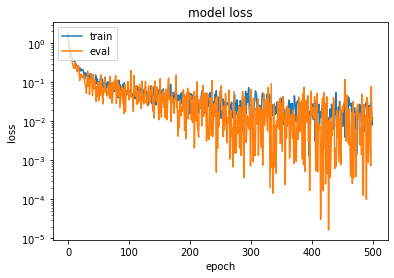

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

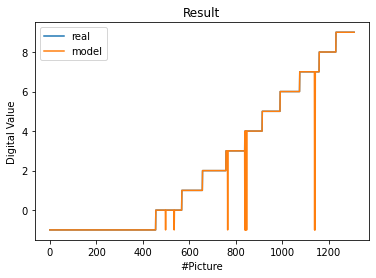

In [6]:
Input_dir='ziffer_sortiert_resize'
subdir = ["NaN", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
res = []

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    if aktsubdir == "NaN":
        zw1 = -1
    else:
        zw1 = int(aktsubdir)
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = -1
        zw2 = classes
        zw3 = zw2 - zw1
        res.append(np.array([zw1, zw2, zw3]))

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpoyax8vna\assets


1303008

In [8]:
FileName = TFliteNamingAndVersion + "q"

import tensorflow as tf

def representative_dataset():
    for _ in range(500):
      data = np.random.rand(1, 32, 20, 3) * 255
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName + ".tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpwy9i2ox_\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpwy9i2ox_\assets


338112

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


In [9]:
Input_dir='ziffer_sortiert_resize'
only_deviation = True

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    expected_class = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = "NaN"
        if only_deviation == True:
            if str(classes) != str(expected_class):
                print(aktfile + " " + aktsubdir +  " " + str(classes))
        else:
            print(aktfile + " " + aktsubdir +  " " + str(classes))


ziffer_sortiert_resize/0\0_nt1_20210626-090405.jpg 0 NaN
ziffer_sortiert_resize/0\D6_2020-08-16_01-02-52.jpg 0 NaN
ziffer_sortiert_resize/3\1_ht4_20210627-124615.jpg 3 NaN
ziffer_sortiert_resize/4\0_ht6_20210627-212552.jpg 4 NaN
ziffer_sortiert_resize/4\0_ht6_20210627-222846.jpg 4 NaN
ziffer_sortiert_resize/4\10_ht6_20210628-105540.jpg 4 NaN
ziffer_sortiert_resize/4\1_ht6_20210627-092724.jpg 4 NaN
ziffer_sortiert_resize/4\1_ht6_20210627-202210.jpg 4 NaN
ziffer_sortiert_resize/7\D6_2020-08-14_15-13-16.jpg 7 NaN
ziffer_sortiert_resize/7\D7_2020-08-19_22-45-38.jpg 7 NaN


Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.